# 自然言語処理にむけて

画像認識は、もともと画像データが多次元ベクトルで表現されており、
よく似た画像が近いベクトルで表現されるなど、機械学習で処理しやすい前提が整っていました。
一方、自然言語などのテキストは、文字コードが近くても意味が近いわけではありません。
自然言語を機械学習で処理するためには、
テキストの特徴量を多次元ベクトルでうまく表現することが鍵になります。

最後のまとめとして、
自然言語処理を機械学習で扱う方法を考えていきましょう。

__モジュールの準備__


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    import japanize_matplotlib #matplotlibの日本語化  
except ModuleNotFoundError:
    !pip install japanize_matplotlib
    import japanize_matplotlib 
sns.set(font="IPAexGothic") #日本語フォント設定


## 形態素解析

言語における意味の基本単位は語 (word) です。まず、語を取り出す方法からみていきましょう。

### 英語と日本語

自然言語処理は、言語の種類によって難しさや扱い方が異なります。

* (英語文) I bought a book 
* (日本語文) 私は本を買った

英語は、空白で区切られたものを語と考えることができます。
したがって、Python の標準文字列ライブラリだけで、簡単に語を取り出すことができます。

__英語の字句解析__

In [2]:
s = "I bought a book"
s.split()

['I', 'bought', 'a', 'book']

日本語では、まず語の区切りを判定する必要があります。
しかし、この語の区切りを判定するのが かなりの難処理です。
この難処理を行ってくれるのが**形態素解析ライブラリ**です。






### spaCy/GINZA

spaCy は、Explosion AI 社の開発するオープンソースの自然言語処理ライブラリです。2019 年に、 リクルート AI 研究所と国立言語研究所の研究成果である GiNZA が登場し、実用的な日本語処理が 手軽に利用できるようになりました。

まずは、GiNZA の導入から始めましょう。`pip install ginza` を入力するだけで、 spaCy を含めて、自然言語処理に必要なライブラリがまとめてインストールされます。

```
!pip install ginza
import pkg_resources, imp
imp.reload(pkg_resources)
```


In [3]:
import spacy
nlp = spacy.load('ja_ginza') 

doc = nlp("私は本を買った") #形態素解析
for word in doc:
    print(word.i, word.orth_, word.lemma_, word.pos_, word.tag_)

0 私 私 PRON 代名詞
1 は は ADP 助詞-係助詞
2 本 本 NOUN 名詞-普通名詞-一般
3 を を ADP 助詞-格助詞
4 買っ 買う VERB 動詞-一般
5 た た AUX 助動詞


日本語文を単語単位に分割する関数を定義しておきましょう。

In [4]:
def wakachi(s):
    doc = nlp(s)
    return [word.lemma_ for word in doc]  # word.lemma_ は標準形

print(wakachi('私は本を買った'))


['私', 'は', '本', 'を', '買う', 'た']


<div class="alert alert-info">

Let's try

自然言語処理と形態素解析の良い練習問題は、「自然言語処理１００本ノック」にあります。

http://www.cl.ecei.tohoku.ac.jp/nlp100/

Web上には、解説記事がたくさん掲載されていますので、参考にしながら解いてみると実力がつきます。

</div>


## アンケート分析

不動産屋による「まちづくりに関するアンケート」に基づいて、アンケート解析を試していきましょう。
アンケードには、アンケートの回答日、コメント自由記述形式、満足度(5段階評価: 1 不満 - 5 満足)が記載されています。

__データの取り寄せ__

本データは、下山らによる「Python 実践データ分析 100 本ノック」から講義用に編集したも のを使っています。

```
!wget https://KuramitsuLab.github.io/data/survey.csv
```

In [16]:
data = pd.read_csv("survey.csv")
data.head() #最初の5行を表示

,日付,コメント,満足度
0,2019/3/11,駅前に若者が集まっている,1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる（待機児童なし）,4
4,2019/1/6,駅前商店街が寂しい,2


### コメントを眺める 

今まで、様々なデータを扱ってきましたが、
今回のデータは、自由記述形式のテキストが入っているのが特徴です。

まず、アンケート中のコメントの分量を把握してみましょう。
文字数を数えて、新しいカラム(`文字数`)を作って格納します。

In [18]:
data["文字数"] = data["コメント"].str.len()

(array([12., 24., 22., 10.,  6.,  6.,  5.,  0.,  0.,  1.]),
 array([ 4. ,  8.6, 13.2, 17.8, 22.4, 27. , 31.6, 36.2, 40.8, 45.4, 50. ]),
 <BarContainer object of 10 artists>)

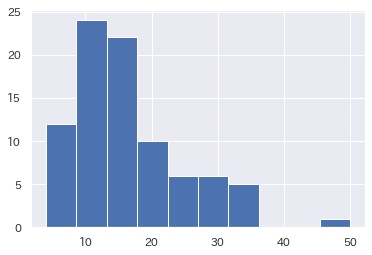

In [19]:
plt.hist(data["文字数"])

以上に長いコメントがありますね。

In [20]:
data.sort_values(by="文字数")

,日付,コメント,満足度,文字数
41,2019/2/25,特になし,3,4
69,2019/1/4,特になし,2,4
25,2019/1/21,道が綺麗,4,4
18,2019/3/15,夜道が暗い,1,5
19,2019/2/20,ゴミ処理が楽,4,6
...,...,...,...,...
62,2019/3/19,アンケートをちゃんと確認して街づくりに反映してくれている姿勢が良い,5,33
56,2019/4/13,歩行者用信号が変わるのが早い。老人や子供の事を考えて設定してほしい,2,33
44,2019/2/28,信号のない交差点が近くにあり事故が起きそうで怖い、信号を付けて欲しい。,1,35
39,2019/3/11,変なおじさんに声を掛けられた事がある。警察の巡回をもっと強化してほしい,1,35


### 単語レベルの解析

コメントから単語を抽出して、どのような単語が使われているか調べてみましょう。

* 標準形変換: 活用のある単語（例. 「買った」）は、買うのように標準形に変換する
* [ストップワード除外](https://mieruca-ai.com/ai/nlp-stopwords/#toc_2-1): 解析の精度を上げるために不要な記号や単語を取り除く

ここでは、動詞、形容詞、名詞だけに着目してみます。

In [21]:
words = []
for text in data["コメント"]:
    doc = nlp(text)
    for word in doc:
        # 動詞(VERB), 名詞(NOUN), 形容詞(ADJ)のみ抽出
        if word.pos_ == 'VERB' or word.pos_ == 'NOUN' or word.pos_ == 'ADJ':
            words.append(word.lemma_)
print(len(words))
print(words[:30])

375
['駅前', '若者', '集まる', 'スポーツ', '場所', 'ある', '良い', '子育て', '支援', '嬉しい', '保育園', '入れる', '待機児童', 'なし', '駅前', '商店街', '寂しい', '生活', '便利', '遊ぶ', '場所', 'ない', '遊ぶ', '場所', 'ない', '商業', '施設', '出来る', '欲しい', '病院']


これで、コメント文の中で用いられている名詞と動詞をすべて取り出すことができました。しかし、
まだどれの単語が重要なのかわかりません。各単語の出現頻度を調べてみましょう。

In [23]:
pd.DataFrame({"words":words}).value_counts()


words
欲しい      15
ほしい      14
少ない       7
駅前        7
良い        6
         ..
大丈夫       1
奇麗        1
姿勢        1
子ども       1
高齢者       1
Length: 228, dtype: int64

これで不動産の満足度に影響を与えているキーワードが見えてきました。しかし、まだどのキーワードがプラスの評価なのか、マイナスの評価なのかわかりません。

<div class="alert alert-info">

Let's try

満足度の高いキーワードを抽出してみよう

</div>

### 満足度の高いキーワード

今回のアッケート調査の素晴らしいことは、不動産の満足度が 5 段階評価で回答されています。
各キーワードとこの5段階評価を紐付けてみると、キーワードの満足度が見えて来るかもしれません。 
(見えてくるかもというだけで、保証はありません。)

まず、名詞と動詞を抽出したとき、アンケート結果の満足度も対応付けるように取り出します。


In [24]:
words = []
scores = []
for text, score in zip(data["コメント"], data["満足度"]):
    doc = nlp(text)
    for word in doc:
        if word.pos_ in ['VERB', 'NOUN', 'ADJ']:
            words.append(word.lemma_)
            scores.append(score)
print(words)
print(scores)

['駅前', '若者', '集まる', 'スポーツ', '場所', 'ある', '良い', '子育て', '支援', '嬉しい', '保育園', '入れる', '待機児童', 'なし', '駅前', '商店街', '寂しい', '生活', '便利', '遊ぶ', '場所', 'ない', '遊ぶ', '場所', 'ない', '商業', '施設', '出来る', '欲しい', '病院', '充実', 'サイクリングコース', '良い', 'お祭り', '盛り上げる', '欲しい', '小学校', '綺麗', '嬉しい', '公園', '欲しい', '近く', '公園', 'ある', '住む', 'スーパー', '行く', '大変', '子育て', 'デート', 'スポット', '欲しい', '商店街', '盛り上げる', 'ほしい', '夜道', '暗い', 'ゴミ', '処理', '楽', '映画館', '欲しい', '街路樹', '欲しい', '公園', '追加', '欲しい', '観光', 'スポット', 'ない', '子育て', 'する', '道', '綺麗', '都内', 'アクセス', '良い', '家賃', 'リーズナブル', 'bbb', '渋滞', 'する', '欲しい', '商店街', '屋根', 'ない', '雨', '降る', '大変', '商店街', '喫茶店', '欲しい', 'スポーツジム', 'ある', '利用', 'スポーツジム', '利用料金', '高い', '働く', 'ママ', '支援', '増やす', '欲しい', 'バス', 'くる', '自転車', '走る', 'ランニング', '運動', '場所', '多い', '有名', '企業', '多い', '駅前', '駐車場', '足りる', '変', 'おじ', 'さん', '声', '掛ける', '事', 'ある', '警察', '巡回', '強化', 'ほしい', '消防団', '活発', '安心', 'なし', '災害', '時', '避難', '場所', '少ない', '気', 'する', '最近', '川', '氾濫', '被害', '大きい', '取り扱う', '町', '氾濫', '防止', '取る', '説明', 'ほしい', '信号', 'ない', '交差点'

In [29]:
keyword = pd.DataFrame({"キーワード": words, "満足度": scores, "出現数": [1]*len(words)})
keyword.groupby('キーワード').agg({'満足度': np.mean, '出現数': sum}).sort_values(by='出現数')

,満足度,出現数
キーワード,,
bbb,2.000000,1
暗い,1.000000,1
暮らせる,5.000000,1
最高,5.000000,1
有名,3.000000,1
...,...,...
良い,4.833333,6
少ない,1.142857,7
駅前,1.428571,7


<div class="alert alert-info">

Let's try

満足度の高いキーワードと満足度の低いキーワードのトップ 5 を出してみよう

</div>

今回の分析は、出現頻度のあまりに低い単語を除外した方が良いです。このように、データサイエ ンティスト(分析者)のセンスで、結果は少し変わります。


## 文章のベクトル化

次は、いよいよ文章のベクトル化を考えていきます。
ポイントは、意味や内容が近い文章は近くなるようにベクトル化することです。
類似文章検索として研究されてきました。


### BOW

**BOW(Bag of Words)** は最も古典的な文書の特徴量を捉えてベクトル化する手法です。
出現する単語の個数を $N$ とすると、各コメント文は出現した単語には 1 を入れた $N$ 次元のベクトルで表現します。


単語の並びを無視しているので Bag of Words（以後、BOW）と呼ばれます。語順を無視すると重要な情報が飛んでしまいそうな気がしますが、類似文書検索タスクでは、十分精度がでます。



BOW のポイントは、文章の構造は全て無視し、「どの単語が含まれているか」だけに注目している点です。そして、一旦、コメント文をベクトルで表現できれば、**コサイン類似度 (cosine similarity) **を用いて、類似度を求めることができます。

BOW の原理は、難しくありません。sklearnモジュールの`CountVectorizer`を使って、楽に BOW を求めることができます。ただし、sklearn は、英語圏で開発されたライブラリなので、入力文は英単語のように空白で区 切られているという前提になっています。日本語は、形態素解析を使って前処理して、テキストを空白区切りの形式に変換しておく必要があります。


In [32]:
data['わかち書き'] = data['コメント'].map(lambda x: ' '.join(wakachi(x)))
data.head()

,日付,コメント,満足度,文字数,わかち書き
0,2019/3/11,駅前に若者が集まっている,1,12,駅前 に 若者 が 集まる て いる
1,2019/2/25,スポーツできる場所があるのが良い,5,16,スポーツ できる 場所 が ある の が 良い
2,2019/2/18,子育て支援が嬉しい,5,9,子育て 支援 が 嬉しい
3,2019/4/9,保育園に入れる（待機児童なし）,4,15,保育園 に 入れる （ 待機児童 なし )
4,2019/1/6,駅前商店街が寂しい,2,9,駅前 商店街 が 寂しい


In [42]:
from sklearn.feature_extraction.text import CountVectorizer
docs = np.array(data['わかち書き'])
model = CountVectorizer()
bags = model.fit_transform(docs)

print(bags.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Pandasで表デートしてみてみましょう。

In [60]:
pd.DataFrame(bags.toarray(),columns=model.get_feature_names(),index=data['コメント']).head()

,bbb,あまり,ある,いる,おじ,お祭り,から,くる,くれる,けど,...,隣町,集まる,電話,頻繁,駅前,駐車場,駐輪場,高い,高速道路,高齢者
コメント,,,,,,,,,,,,,,,,,,,,,
駅前に若者が集まっている,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
スポーツできる場所があるのが良い,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
子育て支援が嬉しい,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
保育園に入れる（待機児童なし）,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
駅前商店街が寂しい,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


文章をベクトル化できれば、あとは類似度を計算するだけです。計算の仕方もいろいろですが、コサイン類似度を用いることが多いです 。ベクトルの向きがどの程度同じ方向を向いているか？という指標で、－１～１の範囲をとります。コサイン類似度を数式で記述すると以下のようになります。
$$
cos(θ)= 
∥ 
x
 ∥∥ 
y
​	
 ∥
x
 ⋅ 
y
​	
 
​	
 = 
∑ 
i
​	
 x 
i
2
​	
 
​	
 × 
∑ 
i
​	
 y 
i
2
​	
 
​	
 
∑ 
i
​	
 x 
i
​	
 y 
i
​	
 
​	
 
$$

In [ ]:
def cosin_similarity(x, y):
    return np.dot(x, y)/(np.sqrt(np.dot(x, x))*np.sqrt(np.dot(y, y)))

### TF/IDF

BOW は、単語の出現を見るだけで、重要度はわかりません。前回、勉強した TF/IDF を組み合わ せることで、出現に重み付けすることができます。こちらも、scikit-learn のライブラリを用いることができます。

TF-IDF は Term Frequency – Inverse Document Frequency の略で、文書中の単語の重要度を評価する手法の一つです。Solr や Elastic Search で有名な Lucene でも少し前までデフォルトのアルゴリズムだったのでご存じの方も多いかと思います。TF, IDF はそれぞれ以下のような意味合いで、TF と IDF の積が TF-IDF です*1。

TF(t,d) … ある単語(t)がある文書(d)中で何回出現したか
IDF(t) … ある単語(t)が全文書集合(D)中のどれだけの文書で出現したかの逆数
早い話が「ある文書の中で何度も出現する単語は重要度が高いが、多くの文書に共通して出現する単語はそうでもない」と理解してもらえれば良いです。文書 d 中の単語 t の TF-IDF(t, d) は以下のようになります。





In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
# tf-idf

vectorizer = TfidfVectorizer(max_df=0.9) #文書全体の90%以上で出現する単語は無視する
X = vectorizer.fit_transform(data['わかち書き'])
print('feature_names:', vectorizer.get_feature_names())
print('X:')
print(X.toarray())


feature_names: ['bbb', 'あまり', 'ある', 'いる', 'おじ', 'お祭り', 'から', 'くる', 'くれる', 'けど', 'この', 'ごみ', 'さん', 'すぎる', 'する', 'そう', 'たくさん', 'ちゃんと', 'つく', 'できる', 'とき', 'とても', 'どう', 'どのような', 'ない', 'なし', 'なる', 'なん', 'ひどい', 'ほしい', 'ます', 'まち', 'まで', 'もう', 'もっと', 'やすい', 'やめる', 'よう', 'よく', 'よる', 'られる', 'れる', 'アクセス', 'アンケート', 'ゴミ', 'サイクリングコース', 'サポート', 'スポット', 'スポーツ', 'スポーツジム', 'スーパー', 'デート', 'ナンバー', 'バス', 'ホームページ', 'マスコット', 'ママ', 'ランニング', 'リーズナブル', '下さる', '不便', '不安', '不正', '並木', '事件', '事故', '交差点', '他県', '付ける', '企業', '住む', '作る', '便利', '保育園', '信号', '備蓄', '働く', '充実', '先月', '入る', '入れる', '公共', '公園', '公害', '冬場', '凍結', '処理', '出る', '出張所', '出来る', '分かる', '利用', '利用料金', '助かる', '動物園', '反映', '取り扱う', '取る', '商店街', '商業', '喫茶店', '土日', '地域', '場所', '増やす', '変わる', '多い', '夜道', '夜間', '大きい', '大丈夫', '大変', '奇麗', '姿勢', '嬉しい', '子ども', '子供', '子育て', '安全', '安心', '家賃', '寂しい', '対応', '対策', '小学校', '少し', '少ない', '屋根', '巡回', '市長', '広い', '強化', '役所', '待機児童', '後押し', '心配', '怖い', '急行', '投稿', '担当者', '拡幅', '掃除', '掛ける', '支援', '料金', '施設', '早い', '映画館', '暗い

In [64]:
print(X[1, vectorizer.vocabulary_['隣町']])

0.0


In [62]:
pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names(),index=data['コメント']).head()

,bbb,あまり,ある,いる,おじ,お祭り,から,くる,くれる,けど,...,隣町,集まる,電話,頻繁,駅前,駐車場,駐輪場,高い,高速道路,高齢者
コメント,,,,,,,,,,,,,,,,,,,,,
駅前に若者が集まっている,0.0,0.0,0.000000,0.397231,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.580016,0.0,0.0,0.411545,0.0,0.0,0.0,0.0,0.0
スポーツできる場所があるのが良い,0.0,0.0,0.416521,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
子育て支援が嬉しい,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
保育園に入れる（待機児童なし）,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
駅前商店街が寂しい,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.490089,0.0,0.0,0.0,0.0,0.0


In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(model_tfidf.toarray())
print(pca.n_components_)
pc8 = pca.transform(model_tfidf.toarray())


8


In [65]:
from sklearn.decomposition import TruncatedSVD
np.set_printoptions(suppress=True)
# SVD
svd = TruncatedSVD(n_components=8, n_iter=7, random_state=0)
svd.fit(X.toarray())
X = svd.transform(X.toarray())


In [66]:
pd.DataFrame(X,index=data['コメント'])

,0,1,2,3,4,5,6,7
コメント,,,,,,,,
駅前に若者が集まっている,7.731770e-02,0.055635,0.221337,0.258149,-0.183296,-0.000305,0.136036,-0.064076
スポーツできる場所があるのが良い,9.653416e-02,0.232015,0.242801,-0.275236,0.224877,-0.002571,0.282702,0.372138
子育て支援が嬉しい,1.530323e-01,0.241557,-0.164930,0.098121,0.093775,-0.002967,-0.276363,0.062022
保育園に入れる（待機児童なし）,1.993400e-07,-0.000112,0.000043,0.000067,-0.000063,0.508183,-0.004800,0.000048
駅前商店街が寂しい,1.475882e-01,-0.066456,0.235868,0.196006,-0.265106,0.001276,-0.074943,0.076161
...,...,...,...,...,...,...,...,...
小学校の校庭が芝生なのでとても良い,3.357989e-02,0.109346,0.002445,-0.019058,0.079640,0.002153,0.071718,0.297933
ホームページからアンケートを投稿できるようにしてほしい,2.061109e-01,0.200964,-0.030146,-0.113776,-0.090526,-0.001596,0.202042,0.033840
公園に遊び道具が少なすぎる,1.735468e-01,-0.023439,0.093533,0.130378,-0.037278,0.001100,0.007060,0.216022


LSI（潜在的意味索引）では、トピックという文書と単語の間に存在する抽象的な概念を導入します。 各文書の BOW あるいは TF-IDF ベクトルを行とする文書数×単語数の行列を特異値分解し、文書数×トピック数に次元削減します。 以下は文章 a ～ d の4つの TF-IDF ベクトルに LSI を適用した場合の図です。

https://www.ogis-ri.co.jp/otc/hiroba/technical/similar-document-search/part1.html


### コサイン類似度



In [46]:
 from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(model_tfidf[0:1],model_tfidf))

[[1.   0.   0.   0.   0.2  0.   0.   0.   0.17 0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.13 0.   0.   0.   0.   0.   0.   0.18 0.   0.   0.
  0.   0.14 0.   0.   0.   0.16 0.   0.12 0.   0.   0.   0.   0.11 0.1
  0.   0.   0.   0.   0.   0.   0.09 0.   0.   0.16 0.13 0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.18]]


## 単語分散表現

文書中の単語出現数を元に文書ベクトルを導出していましたが、ここからは単語の持つ意味的な情報を用いる手法として、単語の分散表現について説明します。 単語の分散表現では単語を多次元空間上の座標にマッピングすることで、単語同士の類似度を比較したり、加減算したりすることができるようになります。「王」－「男」＋「女」≒「女王」という例が有名です。


単語の分散表現の獲得方法は様々な手法が紹介されています。手法の皮切りとして2013年に登場した Word2Vec*2 は 同じ文脈で登場する単語は似た意味を持つという分布仮説をベースとしています。 以下は Word2Vec で実装された CBoW(Continuous Bag of words) の動作イメージです。”Yes We Can” という文章があったとして、周辺単語（”Yes”, “Can”）から注目する単語（”We”）を予測するモデルになります。

### 単語ベクトル


Doc と Span も同様に vector 属性があり、保持する Token の単語ベクトルの平均を返す実装となっています。



In [57]:
doc = nlp('スポーツ')
doc.vector.shape

(300,)

## コースワーク


今回のアンケートでは、自由形式のコメントと満足度を同時に回答するようになっていたため、満 足度の高いキーワードを抽出できました。また、コメント文をベクトル化することで、コメント間 の類似度が求められることも見えてきました。

<div class="admonition tip">

**演習（文書分類）**

満足度は予測できるのでしょうか?

</div>

これは、エントリーシートから(採用後の)満足度は予想できるのでしょうか?と同じ質問になります。
皆さんは AI がエントリーシートを判定しているという噂を聞いたことがありますね。

<div class="admonition tip">

**演習（エントリシート）**

企業がどのように AI を活用して、エントリーシートを分析しているか
考察してみよう。

</div>

今まで学んできた知識を総動員して、もし足りなかったら追加で調査して考えてみましょう。
